<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DDDM/blob/main/COIN/formation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import networkx as nx
import numpy as np

Agents: followers

In [44]:
n = 70 # total followers

Positions

In [45]:
pos = np.random.random((n, 2)) # x and y positions
pos[:5]

array([[0.80725326, 0.96808813],
       [0.76401756, 0.13331471],
       [0.6124246 , 0.03392288],
       [0.33120396, 0.57618421],
       [0.984643  , 0.1918334 ]])

Place *k* leaders using *k*-means on the initial follower positions.

In [46]:
k = 5 # leader agents
from sklearn.cluster import KMeans
clustering = KMeans(n_clusters = k, n_init='auto').fit(pos)
leaders = clustering.cluster_centers_
groups = clustering.labels_
print(leaders[:5])
print(groups[:5])

[[0.19223412 0.78114525]
 [0.82902166 0.2981612 ]
 [0.44012063 0.08121673]
 [0.32676882 0.48000799]
 [0.83618584 0.83546578]]
[4 1 2 3 1]


We should store the coordinates in the graph for ease of access

In [47]:
G = nx.DiGraph()
for f in range(n): # place followers 0, 1, ..., n - 1
  G.add_node(f, pos = pos[f])
for l in range(k):
  G.add_node(n + l, pos = leaders[l]) # call the leaders n, n + 1, n + k - 1

Associate each follower to its leader

In [48]:
for f in range(n): # followers 0, 1, ..., n - 1
  l = n + groups[f] # leaders n, n + 1, n + k - 1
  G.add_edge(f, l)

Let's see the follower graph

In [49]:
import seaborn as sns
tones = sns.color_palette('husl', k)

In [50]:
roles = [ tones[groups[i]] if i < n else tones[i - n] for i in range(n + k)] # distinguish groups
coords = nx.get_node_attributes(G, 'pos') # where to position the agents
size = 15
sizes = [ size if i < n else 3 * size for i in range(n + k) ] # leaders drawn thrice as big

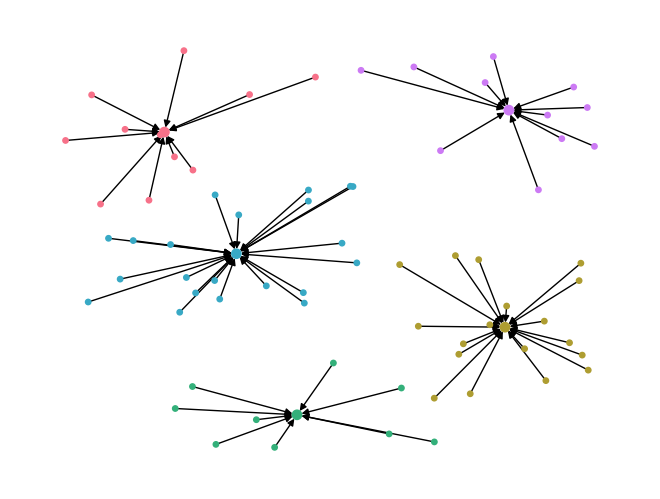

In [51]:
nx.draw(G, coords, node_size = sizes, node_color = roles) # see the agents and the follow relations

Make the leaders move around

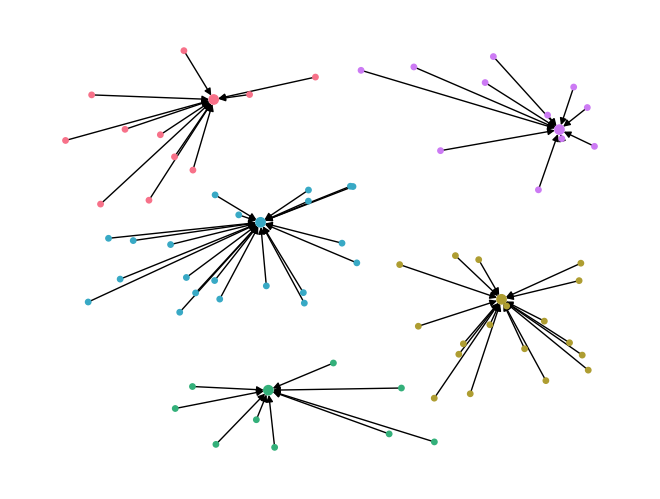

In [52]:
import matplotlib.pyplot as plt

def update(xy, magnitude = 0.1):
  xy += np.random.uniform(-magnitude, magnitude, 2)
  return (np.clip(xy, 0, 1))

def leadersmove():
  global G
  for i in range(n, n + k):
    G.nodes[i]['pos'] = update(G.nodes[i]['pos'])

def step(t = 0):
  plt.clf()
  leadersmove()
  nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size = sizes, node_color = roles)

step()

Put is all in an initialization routine to be able to recreate animations.

In [53]:
def reset():
  global G, tones, roles, sizes, groups
  pos = np.random.random((n, 2)) # x and y
  clustering = KMeans(n_clusters = k, n_init = 'auto').fit(pos)
  leaders = clustering.cluster_centers_
  groups = clustering.labels_
  G = nx.DiGraph()
  for f in range(n): #  followers 0, 1, ..., n - 1
    G.add_node(f, pos = pos[f])
  for l in range(k):
   G.add_node(n + l, pos = leaders[l]) # leaders n, n + 1, n + k - 1
  for f in range(n):
    l = n + groups[f]
    G.add_edge(f, l)
  tones = sns.color_palette('husl', k)
  roles = [ tones[groups[i]] if i < n else tones[i - n] for i in range(n + k)] # distinguish groups
  sizes = [ size if i < n else 3 * size for i in range(n + k) ] # leaders drawn thrice as big

Let's see this in action

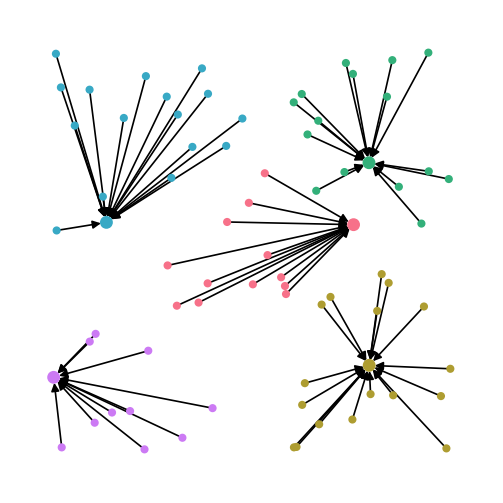

In [54]:
from matplotlib import rc
rc('animation', html='jshtml')
import matplotlib.animation as animation

fig = plt.figure(figsize = (4, 4), dpi = 120)
plt.clf()
animation.FuncAnimation(fig, step, frames = 5, repeat = False, init_func = reset)

Now, make the followers keep up with their leaders

In [55]:
from math import sqrt, fabs

def followersmove(ideal = 0.15, threshold = 0.02, prop = 0.2): # what distance to seek, where to stay still, and how fast to adjust
  global G
  moved = 0
  for f in range(n):
    fp = G.nodes[f]['pos']
    lp = G.nodes[n + groups[f]]['pos']
    d = lp - fp # the position difference of the follower towards its leader
    eucl = sqrt(np.sum(d * d))
    adj = eucl - ideal
    speed = prop * adj # bigger movements when further away
    if fabs(adj) > threshold:
      G.nodes[f]['pos'] += speed * d
      moved += 1
  return moved

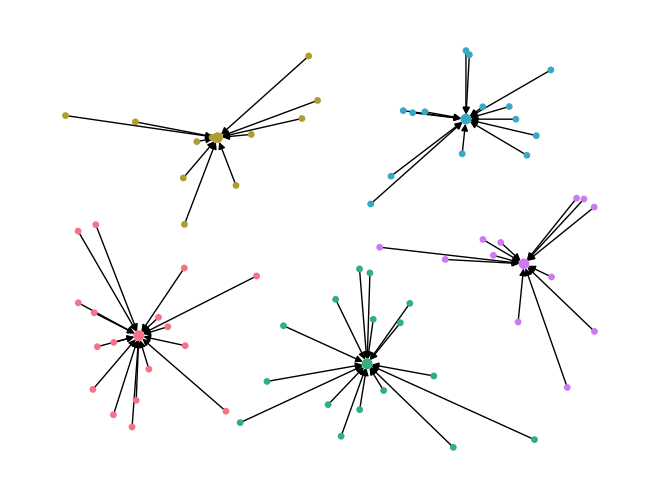

In [56]:
reset()
plt.clf()
nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size = sizes, node_color = roles)

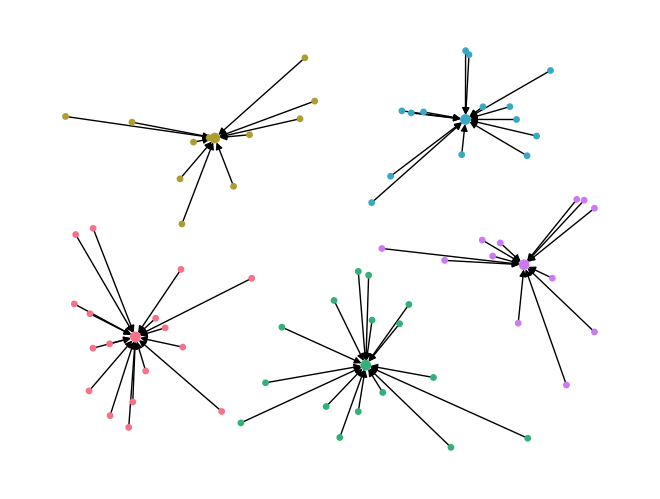

In [57]:
followersmove()
plt.clf()
nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size = sizes, node_color = roles)

150


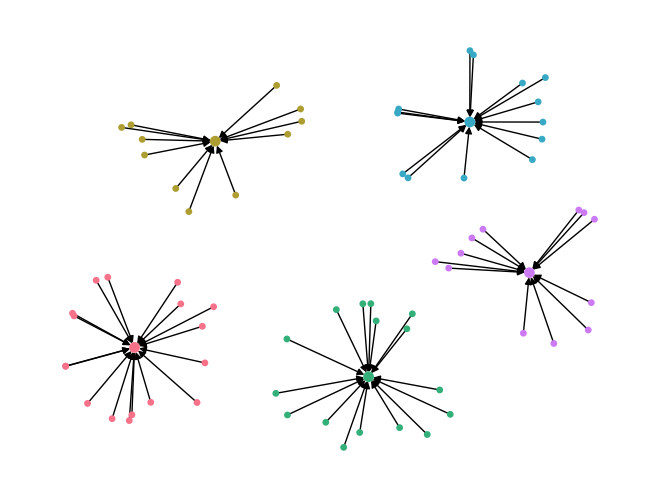

In [58]:
counter = 0
while True:
  c = followersmove()
  if c == 0:
    break
  counter += 1
print(counter)
plt.clf()
nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size = sizes, node_color = roles)

Combine the two types of movements.

In [59]:
def twostep(t = 0):
  plt.clf()
  if followersmove() < n / 2:
    leadersmove() # the majority is caught up, leaders can move again
  nx.draw(G, nx.get_node_attributes(G, 'pos'), node_size = sizes, node_color = roles)

Animate again, starting fresh

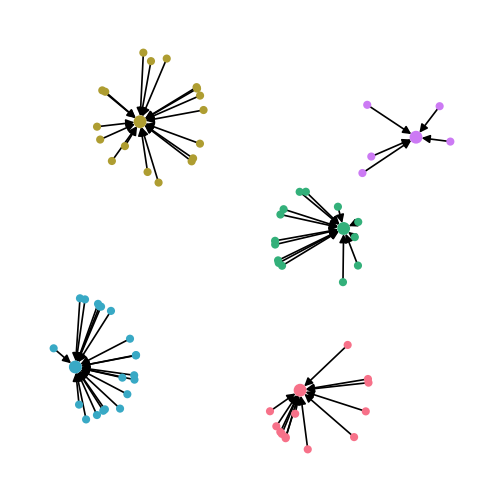

In [60]:
fig = plt.figure(figsize = (4, 4), dpi = 120)
plt.clf()
animation.FuncAnimation(fig, twostep, frames = 100, repeat = False, init_func = reset) # will take a long time if there are many frames and/or n is large